<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# Caso-taller: Identificando  Burger Master con MMG

El Burger Master es un evento creado en el 2016 por el *influencer* Tulio Zuluaga, más conocido en redes como Tulio recomienda, el cual busca que por una semana las hamburgueserías de cada ciudad ofrezcan su mejor producto a un precio reducido. 

El evento ha venido creciendo y en el 2022 se extendió por 21 ciudades de Colombia para las cuales se estimó que se vendieron más de dos millones de hamburguesas. El objetivo del presente caso-taller  es identificar los puntos calientes de hamburgueserías  que compitieron en  la ciudad de Bogotá aplicando aplique el modelo de Mezclas Gaussianas

## Instrucciones generales

1. Para desarrollar el *cuaderno* primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "entrega calificada por el personal".

4. El archivo entregado debe poder ser ejecutado localmente por el tutor. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos en el mismo `path` de su cuaderno, por ejemplo: `data`.

## Desarrollo

### 1. Carga de datos  

En los `Archivos de Laboratorio`, en la carpeta `data` se encuentra el archivo `burgar_master.xlsx` para la ciudad de Bogotá, cargue estos datos en su *cuaderno*. 


In [ ]:
!pip install yellowbrick

import pandas as pd

burger=pd.read_excel('data/burgar_master.xlsx')
print(burger.shape)
burger.head()


You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.
(137, 5)


,Restaurante,Dirección,Descripción,Latitud,Longitud
0,MAIKKI,Cra 75 # 24D – 48,"<p>MAIKKI MACUIRA: Cama de chicharrón soplado,...",4.668833,-74.116828
1,MAIKKI,Calle 119 # 11A – 24,"<p>MAIKKI MACUIRA: Cama de chicharrón soplado,...",4.698395,-74.036585
2,MAIKKI,Cra 47A # 98 – 47,"<p>MAIKKI MACUIRA: Cama de chicharrón soplado,...",4.686401,-74.060144
3,FRENCHEESE,Calle 51 #22-55,"<p>Presentamos «La French Master», inspirada e...",4.639514,-74.073545
4,FRENCHEESE,Calle 80 #14-41,"<p>Presentamos «La French Master», inspirada e...",4.666147,-74.056758


# Analisis

- Se carga el excel en un dataframe usando pandas.
- Se registran 137 puntos de venta que compitieron en el evento de MASTER BURGUER

### 2.  Visualizando los datos

Visualice la ubicación de cada restaurante en un mapa interactivo. Añada un marcador para cada restaurante y la posibilidad de encontrar la descripción de la hamburguesa ofrecida en un pop-up. (Note que la columna Descripción contiene otros datos adicionales a la descripción de la hamburguesa, sea cuidadoso cuando limpie estos datos y describa como los limpió)

In [ ]:
import folium

#funcion para extrater la descripcion cruda
def separar_descripcion(texto):
    items=texto.split('<br/>')
    return items[0].replace('<p>','')

# funcion para decorar el popup de cada marcador con formato Html
def decorar_html_popup(texto):
    html='<p style=color: navy>'
    html = html + texto
    html = html + '</p>'
    return  html

# MAIN
burger['dsc_cruda']= burger['Descripción'].apply(lambda texto: separar_descripcion(texto))

# Definicion de mapa con las coordenadas geoespaciales de Longitud y latitud 
mapa = folium.Map(location = [burger.Latitud.mean(), burger.Longitud.mean()], tiles = "OpenStreetMap", zoom_start = 10)
for i in range(0,len(burger)):
    popup = folium.Popup(folium.Html(decorar_html_popup(burger.iloc[i]['dsc_cruda']), script=True), max_width=500)
    folium.Marker(
      location=[burger.iloc[i]['Latitud'], burger.iloc[i]['Longitud']],
      popup=popup
    ).add_to(mapa)


#Display el mapa
mapa

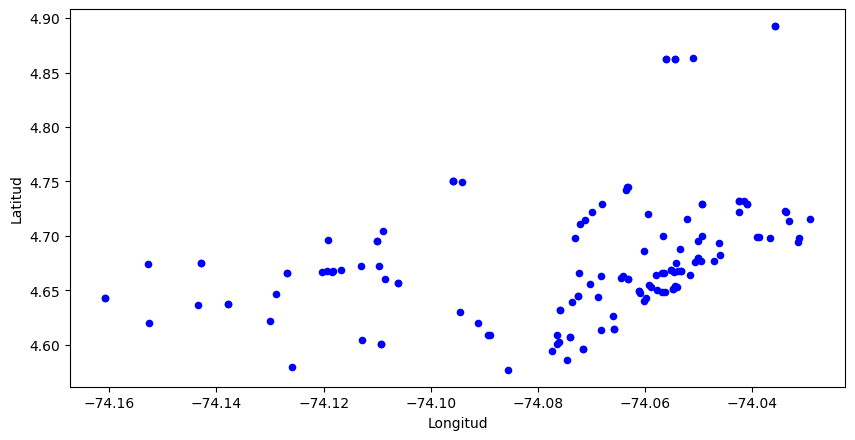

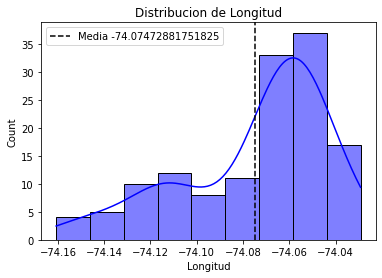

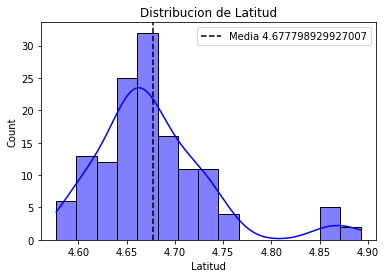

In [ ]:
#!pip install geopandas

import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')



# funcion para plot de Histogramas  de coordenadas
def histogramas_coordenadas(df, columna):
  sns.histplot(df[columna],  kde=True, color='b')
  plt.axvline(df[columna].mean(), color='k', linestyle='--', label=f'Media {df[columna].mean()}')
  plt.title(f'Distribucion de {columna}'); 
  plt.legend()
  plt.show()


## MAIN

# Crear geodataframe desde dataframe de delitos para obtener la geometria activa  de puntos con base en la longitud y latitude
burgers_gpd = gpd.GeoDataFrame(burger,crs="EPSG:4326", geometry = gpd.points_from_xy(burger.Longitud, burger.Latitud))
burgers_gpd = burgers_gpd.set_crs("EPSG:4326")
burgers_gpd = burgers_gpd.set_crs(epsg=4326)
fig, ax = plt.subplots(figsize = (10, 5), dpi = 100)
burgers_gpd.plot(kind='scatter', x='Longitud', y='Latitud',ax=ax,color='b')
plt.show()

# Histogramas  de coordenadas
histogramas_coordenadas(burger, 'Longitud')
histogramas_coordenadas(burger, 'Latitud')

# Análisis

- Se crea una función para separar la descripción cruda usando operaciones de 'strings'

- Se crea una funcion para decorar cada marcador con un popup en formato Html 

- En el mapa se observa visualmente tres puntos de concentración . Una   zona con alta densidad  para  Usaquen, Chapinero y Candelaria; otra zona para el resto de Bogota y otra zona para Chia y Cajica
- Visualmente veo algunos puntos atipicos en los alrededores de la localidad   de Fontibón, Tunjuelito y Kennedy, que se discutirán posteriormente

- En los dos histogramas (latitud y longitud) se puede observar dos puntos de masa a saber:
Long: -74.06 y -74.12
Lat: 4.65 y 4.87

- Se carga el dataframe en geopandas para tener la geometría activa de POINT (Lat, Long) y se configura el sistema de referencia de coordenadas a EPSG:4326 

### 3.  Análisis de puntos calientes

Aplique el modelo de Mezclas Gaussianas para buscar clusters de restaurantes en Bogotá, mencione qué estructura de covarianza usó y explique por qué. Escoja el número óptimo de clusters, explicando el procedimiento y justificando su elección.

GaussianMixture(n_components=3, n_init=3, random_state=3)


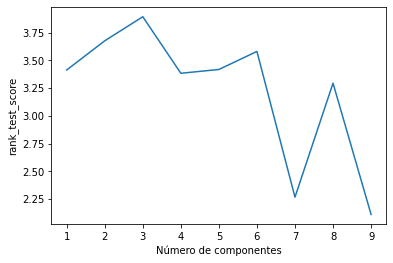

Text(0.5, 0, 'Número de componentes')

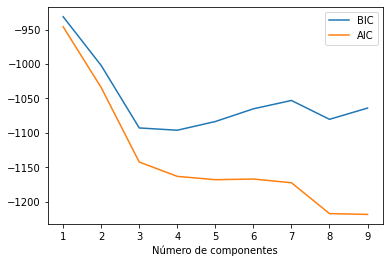

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


### MAIN
X_train=burger[['Longitud','Latitud']]

#Metodo 1: Validacion cruzada
tuned_parameters = {'n_components': range(1,10)} # chequear 1->10 componentes
#construir objecto grid search que usa 5 pliegues de validacion cruzada
clf = GridSearchCV(GaussianMixture(covariance_type='full', random_state=3,n_init=3),tuned_parameters,cv=5)
clf.fit(X_train)
print(clf.best_estimator_)
#plot numero de componentes gausianos versus su score
plt.plot(clf.cv_results_['param_n_components'],
            clf.cv_results_['mean_test_score'])
plt.xlabel('Número de componentes')
plt.ylabel('rank_test_score')
plt.show()

#Metodo 2: AIC y BIC
n_components = range(1, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=3, n_init=3).fit(X_train)
          for n in n_components]

plt.plot(n_components, [m.bic(X_train) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_train) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('Número de componentes')

# Análisis

### Método por validación cruzada

En este metodo  se usa 5 pliegues de validación cruzada para modelar el comportamiento desde 1 componente a 10 componentes gausianos. Dado el mapa y el plot, descarto el uso de convarianza **espherical** (claramente los puntos de masa no se ven esfericos); también descarto el tipo de covarianza **tied** (no todos los componentes comparten la misma matriz de covarianzas) . Se escoge full covarianza porque en general es mejor aunque podria ser propenso al sobreajuste en pequeños datasets y no generalize bien. 
Por otro lado, la mezcla de componentes gausiano  se usa con n_init=3, que es el numero de inicializaciones de los pesos a ejecutar.

El mejor modelo es de 3 componentes gausianos con full covarianza

### AIC y BIC

Por BIC , el numero de componentes es 3. Sin embargo, por AIC se ve que son 8 componentes, pero dado que la covarianza es full y con 8 con componentes seria muy complejo el modelo y seguramente con sobreajuste. Por eso me inclino hacia 3 componentes gausianos



#### 3.1. Visualización de los resultados

Visualice en un mapa  el mejor resultado, describa lo que obtiene y argumente porque es el mejor modelo, en su análisis incluya una discusión sobre la presencia o ausencia de ubicaciones atípicas.

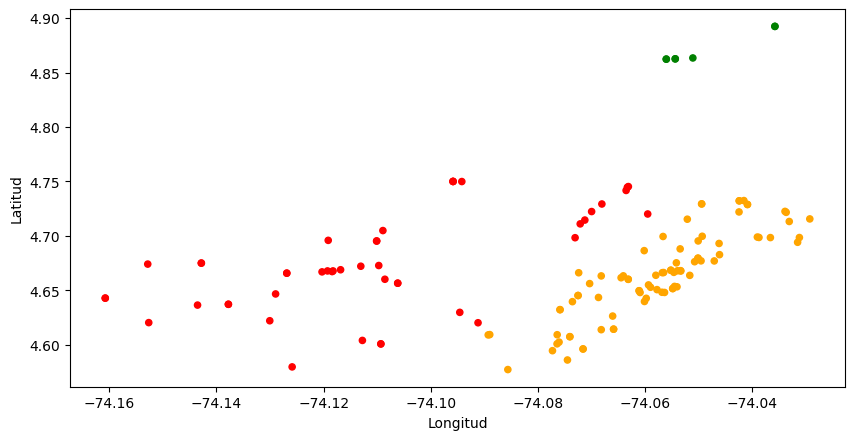

In [ ]:
import numpy as np
import geopandas as gpd

# Funcion para aplicar un color a cada componente     
def aplicar_color_componente(cluster):
    color =['red',
    'orange',
    'green',
    'purple',
    'cadetblue',
    'pink']
    return color[cluster] 

def colorCall(val):
  val = int(val)
  return colour[val]

#MAIN

colour = ['red',   'orange',    'green',    'purple',    'cadetblue',    'pink']
X_train= burger[['Longitud','Latitud']]
# Modelo de mezclas gausianas con 3 componentes
mmg= GaussianMixture(n_components=3, covariance_type='full',n_init=3,random_state=123)
labels = mmg.fit_predict(X_train)
X_train['cluster']=labels
#plot logitud y latitude     
burgers_gpd = gpd.GeoDataFrame(burger,crs="EPSG:4326", geometry = gpd.points_from_xy(X_train.Longitud, X_train.Latitud))
burgers_gpd = burgers_gpd.set_crs("EPSG:4326")
burgers_gpd = burgers_gpd.set_crs(epsg=4326)
fig, ax = plt.subplots(figsize = (10, 5), dpi = 100)
X = X_train.copy()
X['color'] = X['cluster'].apply(lambda cluster: aplicar_color_componente(cluster) )
burgers_gpd.plot(kind='scatter', x='Longitud', y='Latitud',ax=ax,color= X['color'])
plt.show()


#Mapa base
mapa = folium.Map(location = [X_train.Latitud.mean(), X_train.Longitud.mean()], tiles = "OpenStreetMap", zoom_start = 10)
for lat, lon, c in zip(X_train['Latitud'], X_train['Longitud'], X_train['cluster']):
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        fill_color = colorCall(c),
        fill=True,
        color=colorCall(c),
        fill_opacity=0.7
        ).add_to(mapa)
    
#Display el mapa
mapa

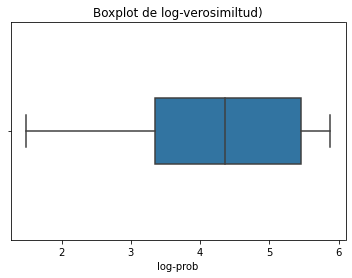

ATIPICOS:

      Longitud   Latitud  cluster
50  -74.152832  4.674034        0
78  -74.125873  4.579557        0
90  -74.160764  4.642762        0
98  -74.109309  4.600693        0
117 -74.109309  4.600693        0
129 -74.160764  4.642762        0


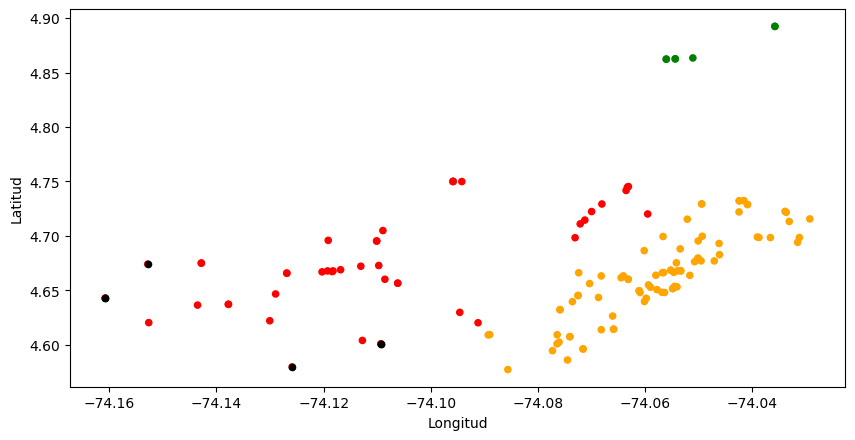

In [ ]:
# Analisis de Outliers

df= X_train.copy()
#Calcule el log-verosimilitud de cada muestra.
df['log_prob']=mmg.score_samples(df[['Longitud','Latitud']])
sns.boxplot( x=df['log_prob'],width=0.3 )
plt.title('Boxplot de log-verosimiltud)')
plt.xlabel('log-prob')
plt.show()

# Voy a  trabajar con el quinto percentil de los log-versomilitud para decir que son atipicos 
densidad_threshold = np.percentile(df['log_prob'], 5)
atipicos = df[df['log_prob'] < densidad_threshold]
print('ATIPICOS:\n')
print(atipicos[['Longitud','Latitud','cluster']])

burgers_gpd = gpd.GeoDataFrame(burger,crs="EPSG:4326", geometry = gpd.points_from_xy(X_train.Longitud, X_train.Latitud))
burgers_gpd = burgers_gpd.set_crs("EPSG:4326")
burgers_gpd = burgers_gpd.set_crs(epsg=4326)
X = X_train.copy()
fig, ax = plt.subplots(figsize = (10, 5), dpi = 100)
X['color'] = X['cluster'].apply(lambda cluster: aplicar_color_componente(cluster) )
burgers_gpd.plot(kind='scatter', x='Longitud', y='Latitud',ax=ax,color= X['color'])

#outliers
atipicos_gpd=gpd.GeoDataFrame(atipicos,crs="EPSG:4326", geometry = gpd.points_from_xy(atipicos.Longitud, atipicos.Latitud))
atipicos_gpd = atipicos_gpd.set_crs("EPSG:4326")
atipicos_gpd.plot(kind='scatter', x='Longitud', y='Latitud',ax=ax,color='black')

plt.show()
#Mapa base
mapa = folium.Map(location = [X_train.Latitud.mean(), X_train.Longitud.mean()], tiles = "OpenStreetMap", zoom_start = 10)

for lat, lon, c in zip(X_train['Latitud'], X_train['Longitud'], X_train['cluster']):
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        fill_color = colorCall(c),
        fill=True,
        color=colorCall(c),
        fill_opacity=0.7
        ).add_to(mapa)
    
for lat, lon in zip(atipicos['Latitud'], atipicos['Longitud']):
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        fill_color = 'black',
        fill=True,
        color='black',
        fill_opacity=0.7
        ).add_to(mapa)
    

#Display el mapa
mapa

# Análisis

- Con tres componentes gausianos como resultado de los métodos de validación cruzada y/o BIC-AIC , al graficarlos sobre el mapa podemos ver tres zonas que visualmente ya habian sido identificadas:

| Cluster      | Descripción |
| ----------- | ----------- |
| Zona 1      | Candelaria, Chapinero y Usaque       |
| Zona 2   | Resto de Bogota        |
| Zona 3   |Chia y Cajica      |

- Importante ver en el mapa  densidades **elipsoidales** y que seran comparadas con la forma del clustering de KMeans. Obviamente esta forma elipsoildal se debe a la escogencia de full covarianza en el modelo de mezclas gausianas.

### Analisis de Oultiers

- En la visualización inicial en el mapa, mi intuición me dice que hay algunos puntos atipicos en las localidades de Fontibón, Keneddy y Tunjuelito.  Por qué?  Por la naturaleza del evento , los precios implican cierto nivel socio económico y en esas localidades podria haber puntos en los cuales algunos restaurantes estan empezando a acoger la idea pero con cierto riesgo y ahi la naturaleza de los outliers.

- Quise ver si a traves del boxplot de scores de log-verosimilitud(log_probabilidad)  se identificaban algunos oultiers pero no se revelaron.
- Por lo tanto, Se toma el 5 percentil de la muestra basado en los scores de log-verosimilitud (mas bajos score de log-verosimiltud) y se muestran en el mapa. Efectivamente , se revelan puntos en Fontibón, Tunjuelito y Kennedy que están en el mapa como marcadores de color negro. Este 5 percentil fue mas mi intuición que otra cosa.



### 4. Comparación con K-medias

Aplique K-medias para buscar clusters de restaurantes en Bogotá. Explique y justifique el criterio que utilizó para la determinación del número de clusters. Visualice en un mapa los resultados. Compare los resultados obtenidos por el "mejor" modelo encontrado via MMG. Explique las similitudes y diferencias de los resultados encontrados con estas dos técnicas y comente sobre el desempeño de ambos.

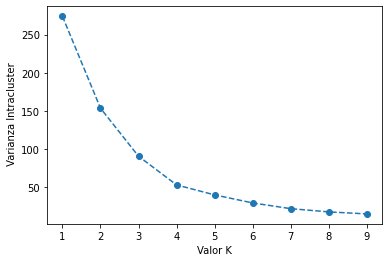

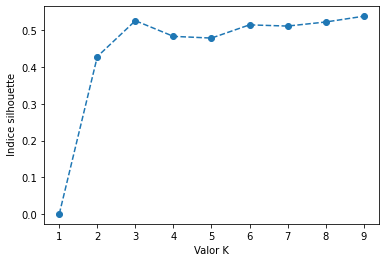

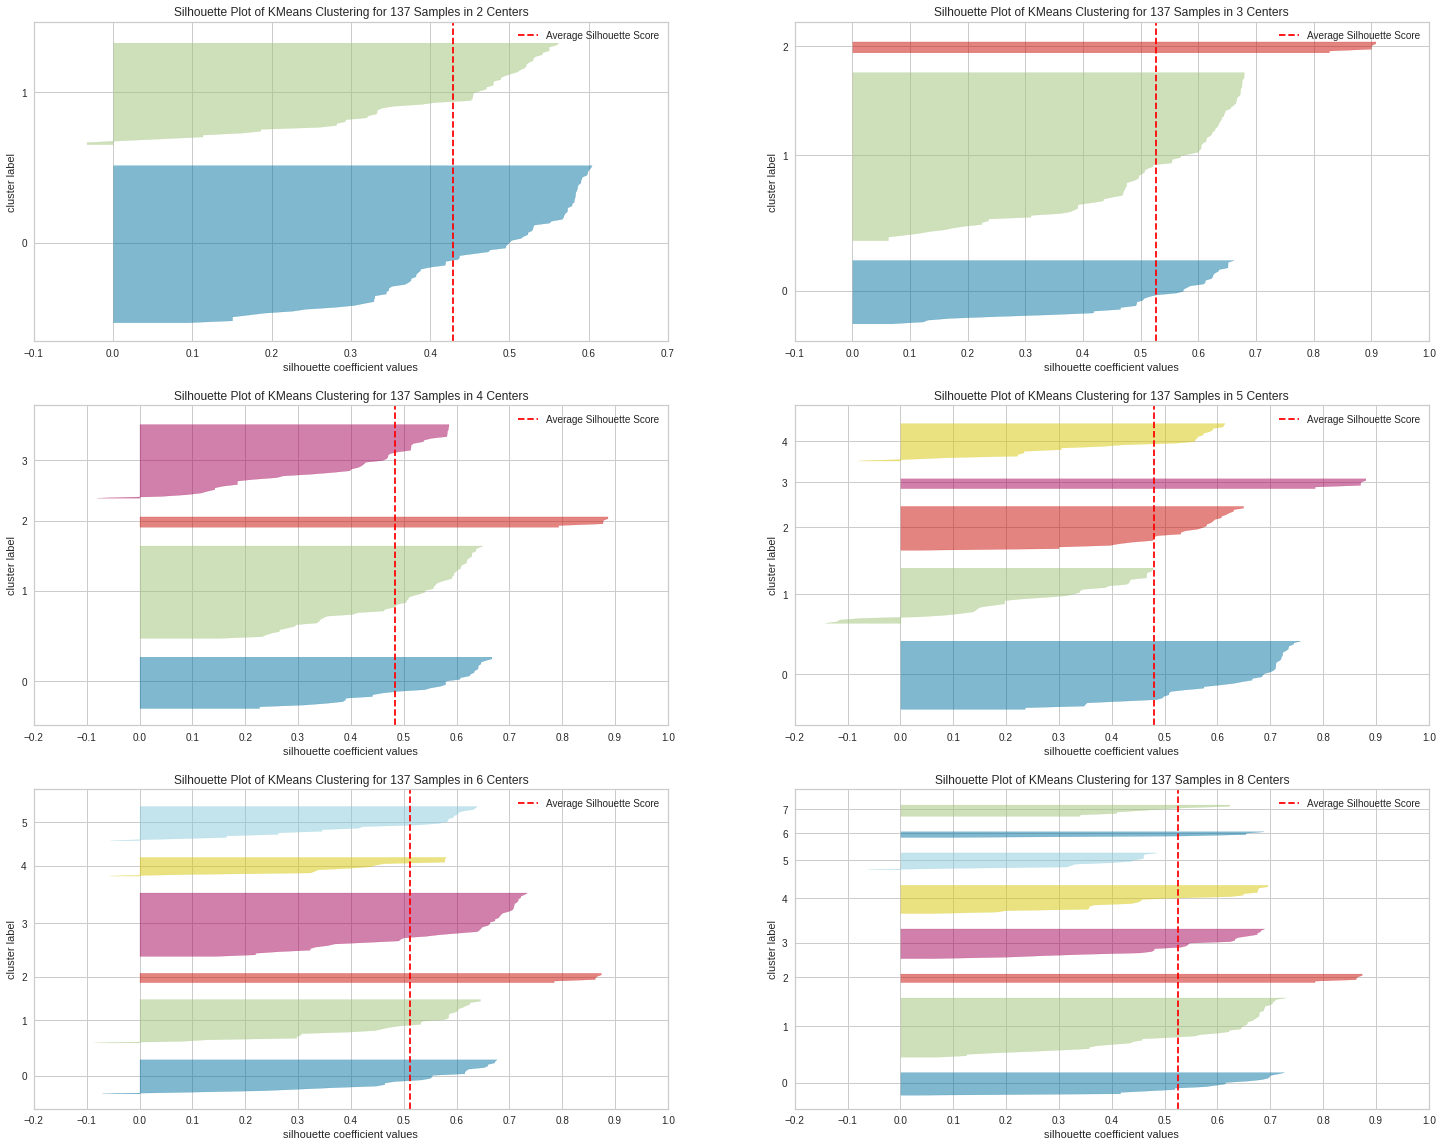

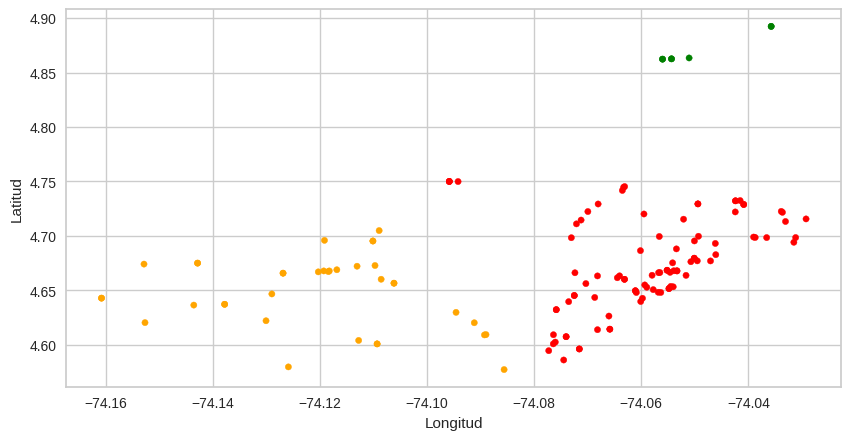

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# MAIN
X_train= burger[['Longitud','Latitud']]
burgers_gpd = gpd.GeoDataFrame(burger,crs="EPSG:4326", geometry = gpd.points_from_xy(X_train.Longitud, X_train.Latitud))
burgers_gpd = burgers_gpd.set_crs("EPSG:4326")
burgers_gpd = burgers_gpd.set_crs(epsg=4326)


# Estandarizar las coordenadas
scaler = StandardScaler()
X_escalado = scaler.fit_transform(X_train)


# Seleccion de numero de clusters dada la distancia intracluster y/o indice de silhoutte
varianza_intra_cluster = []
silhouettes = []
rango=range(1,10)
for k in rango :
    
    model = KMeans(n_clusters=k)
    model.fit(X_escalado)
    
    #Suma de distancias al cuadrado de las observaciones al centro de su closter. varianza intracluster
    varianza_intra_cluster.append(model.inertia_)
    try:
        silhouette = silhouette_score(X_escalado, model.labels_)
    except:
        silhouette = 0 # El índice de Silhouette sólo se puede calcular cuando se tiene K>1
    silhouettes.append(silhouette)
    
    
#plot de varianza intracluster
plt.plot(rango,varianza_intra_cluster,'o--')
plt.xlabel("Valor K")
plt.ylabel(" Varianza Intracluster")
plt.show()

# Plot de Indice silhouettes
plt.plot(rango,silhouettes,'o--')
plt.xlabel("Valor K")
plt.ylabel(" Indice silhouette")
plt.show()


# Visualizacion de silhouettes
from yellowbrick.cluster import SilhouetteVisualizer
fig, ax = plt.subplots(3, 2, figsize=(25,20))
axli = ax.flatten()
j = 0
for i in [ 2,3,4,5,6,8]:
   
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax= axli[j] )
    visualizer.fit(X_escalado)
    visualizer.finalize()
    j+=1


# Seleccionde 3 componentes  segun el indice de sillhoute   
model = KMeans(n_clusters=3)
labels=model.fit_predict(X_escalado)
X_train['cluster']=labels
X = X_train.copy()
X['color'] = X['cluster'].apply(lambda cluster: aplicar_color_componente(cluster) )
fig, ax = plt.subplots(figsize = (10, 5), dpi = 100)
burgers_gpd.plot(kind='scatter', x='Longitud', y='Latitud',ax=ax,color= X['color'])
plt.show()


#Mapa base
mapa = folium.Map(location = [X_train.Latitud.mean(), X_train.Longitud.mean()], tiles = "OpenStreetMap", zoom_start = 10)

for lat, lon, c in zip(X_train['Latitud'], X_train['Longitud'], X_train['cluster']):
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        fill_color = colorCall(c),
        fill=True,
        color=colorCall(c),
        fill_opacity=0.7
        ).add_to(mapa)
mapa

# Análisis
- Por indice de sillhoute , vemos que 3 componentes gausianos es la mejor selección.

- Se corre KMeans con 3 clusters y al graficarlo los diferentes clusters  sobre el mapa, vemos que las formas de los clusters de KMeans no son tan elipsoidales como los del Modelo de mezclas gausiana. Esencialmente  las colas de las elipsoides de los componentes gausianos  pasan a otro cluster en KMeans para hacer los clusters de KMeans mas simetrica(hyperesfera) .

